# Seismic Waves

This notebook provides a really quick look at some of the different types of seismic wave that we
observe on seismograms.  It does not cover any theory, and students should read about how
seismic waves propogate.  You should familiarize yourself with constituitive equations
relating stress to strain in the solid Earth, equations of motion for seismic waves (and
in particular how we arrive at compressional and shear waves from the wave equation) and
how surface waves arise as *guided waves* at interfaces.

Seismic waves are elastic waves in the Earth (or other planetary body). Seismic waves are
generally separating into body waves and surface waves.  Body waves travel through the solid Earth,
surface waves occur at boundaries (most noticeably the Earth's free surface).

- P waves, with velocity: $V_P=\sqrt{\frac{K+4/3\mu}{\rho}}$
- S waves, with velocity: $V_S=\sqrt{\frac{\mu}{\rho}}$
- Surface waves, which are split into *Rayleigh* and *Love* waves.
  - Love waves result from horizontally polarized shear-waves (SH) near the surface;
  - Rayleigh waves result from a combination of P and vertically polarized shear-waves (SV).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Makes plots work well with dark theme

Lets look at some of the complexity that we can see in seismograms, then think about what we see.
We will download some data from a seismograph in Hawaii that recorded a deep focus, large magnitude
earthquake near Tonga. Details for this event can be found on the IRIS website 
[here](http://ds.iris.edu/ds/nodes/dmc/tools/event/10944928).

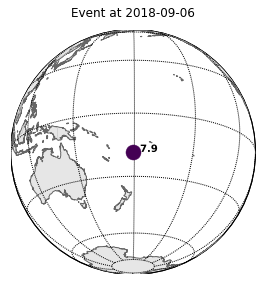

In [2]:
from obspy.clients.fdsn import Client

event_id = "10944928"

client = Client("IRIS")
catalog = client.get_events(eventid=event_id)
fig = catalog.plot(projection="ortho")

Lets download some waveforms for this event and see what waves we observe.  
This deep event generates limited surface-wave energy. Note that we use the events
origin time to specify when we download data.

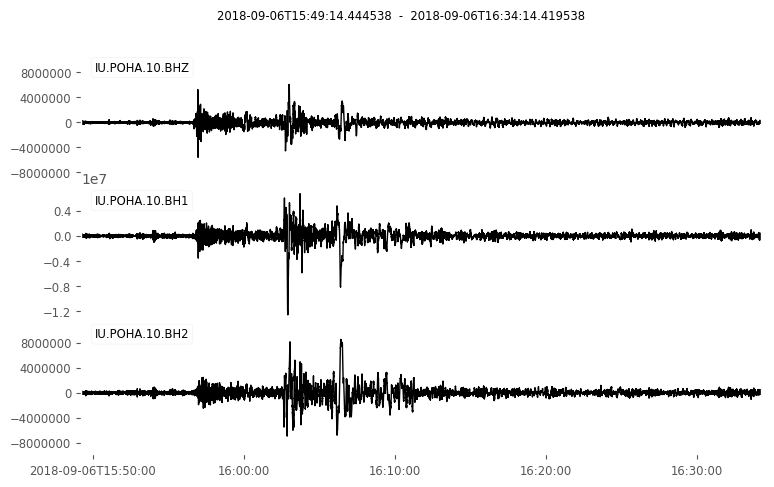

In [3]:
event = catalog[0]
st = client.get_waveforms(
    network="IU", station="POHA", channel="BH?", location="10",
    starttime=event.preferred_origin().time,
    endtime=event.preferred_origin().time + (45 * 60))
fig = st.plot(size=(800, 500))

We can see some clear arrivals, and can clearly see that these have different dominant frequencies.  If you
want you can plot the spectrogram of this event to see the frequency content differences more clearly.
Of note is that we see energy on all three channels, the vertical (BHZ) and the two horizontals (BH1 and BH2:
note that because they are named 1 and 2 rather than N and E they are not aligned to some geographic
references frame, but are still taken to be orthogonal).

If we have a direct P-wave travelling directly up from the source (earthquake) to the receiver (seismograph)
we would expect all the P-wave energy to be recorded on the vertical channel, and the shear-wave energy to be
on the horizontal channels. We would also expect that the shear wave energy might be polarized and therefore
only appear on one or other horizontal component.

We can "rotate" the data if we know the orientation of the instrument, and we can then orient the horizontal
channels into radial and transverse components, with radial aligned along the path between the source and the
reciever and transverse perendicular to this. The code below does this by getting the information about
the site (which in this case contains orientation information), and working out the back-azimuth from the
seismograph to the earthquake.  It also filters the data to make the main phases more clear.

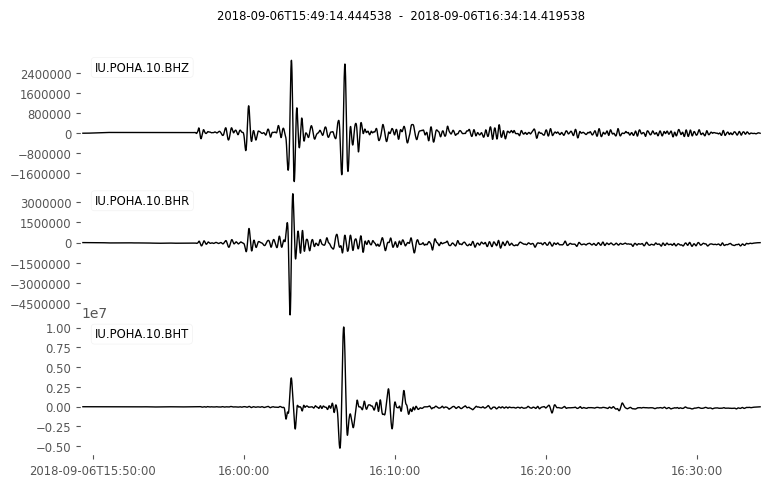

In [4]:
from obspy.geodetics import gps2dist_azimuth

inv = client.get_stations(
    network=st[0].stats.network, station=st[0].stats.station,
    startbefore=st[0].stats.starttime, endafter=st[0].stats.endtime,
    level="response")
network = inv[0]
station = network[0]
dist, az, baz = gps2dist_azimuth(
    lat1=event.preferred_origin().latitude,
    lon1=event.preferred_origin().longitude,
    lat2=station.latitude, lon2=station.longitude)
# Rotate first to ZNE, then to radial and transverse
st.rotate(method="->ZNE", inventory=inv)
st.rotate(method="NE->RT", back_azimuth=baz)

st_filtered = st.copy().detrend().taper(
    max_length=100, max_percentage=20).filter(
    'lowpass', freq=0.05, corners=4)

fig = st_filtered.plot(size=(800, 500), equal_scale=False)

We can see that there is now limited data on the transverse component (BHT) early in the seismogram. There is still
some energy early on the radial component (BHR), which is mostly P-wave energy.  This is present on the radial
and vertical because the source is not directly below the seismograph.

We can use global velocity models to trace ray-paths through the model between the source and receiver.  By
doing this we can predict when we would expect different phases to arrive at the seismograph. Below we use the
[ak135 model](https://academic.oup.com/gji/article/122/1/108/575854) and 
[obspy's Taup](https://docs.obspy.org/packages/obspy.taup.html) wrapper to predict arrival times.

/home/calumch/miniconda3/envs/gphs445/lib/python3.7/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)
/home/calumch/miniconda3/envs/gphs445/lib/python3.7/site-packages/obspy/taup/tau.py:869: UserWarning: Not able to evaluate positions of points on path. Arrivals object will not be modified. Install the Python module 'geographiclib' to solve this issue.
  warnings.warn(msg)


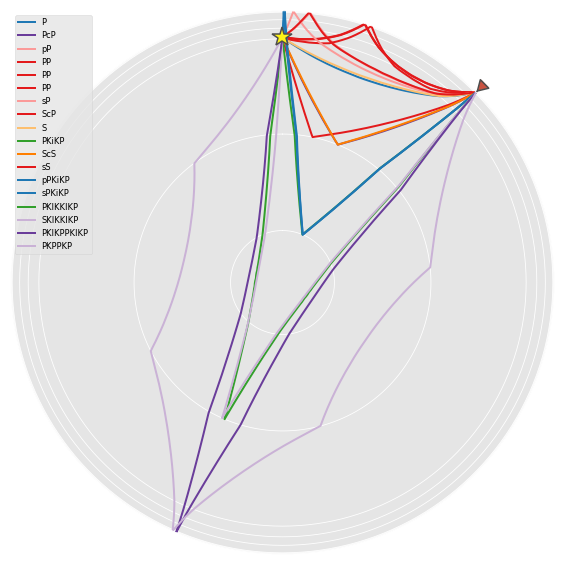

In [5]:
from obspy.taup import TauPyModel

model = TauPyModel(model='ak135')
arrivals = model.get_ray_paths_geo(
    source_depth_in_km=event.preferred_origin().depth / 1000,
    source_latitude_in_deg=event.preferred_origin().latitude,
    source_longitude_in_deg=event.preferred_origin().longitude,
    receiver_latitude_in_deg=station.latitude,
    receiver_longitude_in_deg=station.longitude,
    phase_list=["ttbasic"])
fig = plt.figure(figsize=(10, 10))
# NBVAL_IGNORE_OUTPUT
fig = arrivals.plot_rays(plot_type='spherical', legend=True, fig=fig)

In the plot above we can see the source as a star, and the reciever as a triangle. There are a range of ray-paths
plotted, including direct arrivals and reflected and refracted arrivals. This superposition of many ray-paths
is one of the factors that gives rise to more complicated seismograms.  Note that this idea of rays in the Earth is
a simplification (allbeit a useful one).

We can plot the predicted arrival times on our seismogram and see if where they are predicted lines up with
the arrivals, and if the type of wave matcches what we expect given our knowledge of P-waves as compressional
waves and S-waves as shear waves.

In [6]:
def plot_arrivals(st, arrivals):
    """
    Plot arrival times on waveforms.
    
    :type st: `obspy.core.Stream`
    :param st: Stream to plot
    :type arrivals: list
    :param arrivals: List of Arrivals from an obspy Taup model.
    """
    from obspy.taup.tau import COLORS

    fig = plt.figure(figsize=(11, 9))
    fig = st.plot(equal_scale=False, fig=fig)
    axes = fig.axes
    phase_names = [arrival.name for arrival in arrivals]
    for ax in axes:
        for arrival in arrivals:
            if ax == axes[0]:
                label = arrival.name
            else:
                label = None
            ax.axvline(x=(event.preferred_origin().time + arrival.time).datetime,
                       color=COLORS[phase_names.index(arrival.name) % len(COLORS)],
                       label=label)
    fig.legend()
    return fig

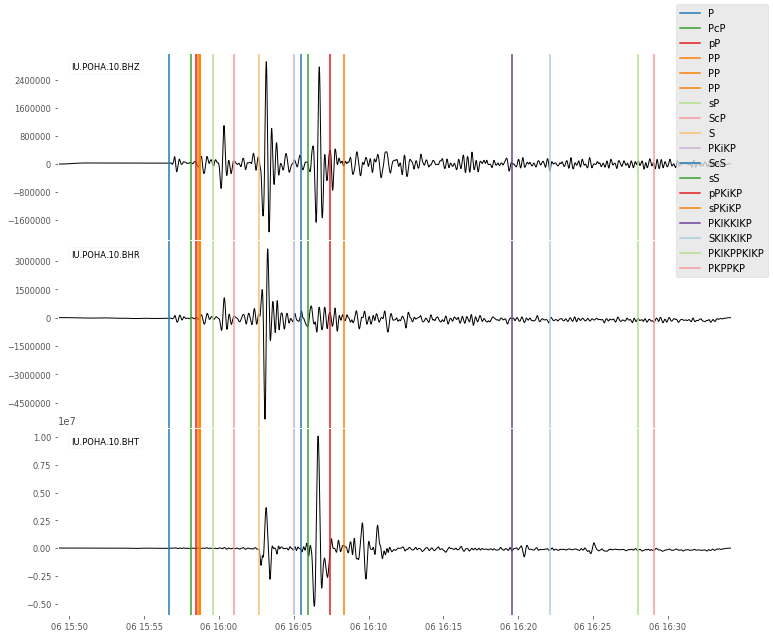

In [7]:
fig = plot_arrivals(st_filtered, arrivals)

**Question:** Do the major arrivals in the seismograms match to predicted arrival times? What do you think the amplitude 
portioning between channels means for the polarization of the S (direct) and sS (reflected off the Earth's surface) phases?

**Answer:**

Because we have orthogonal components we can look at the particle motion.  Lets look at the
particle motion in the horizontal plane for the P, S and sS arrivals.

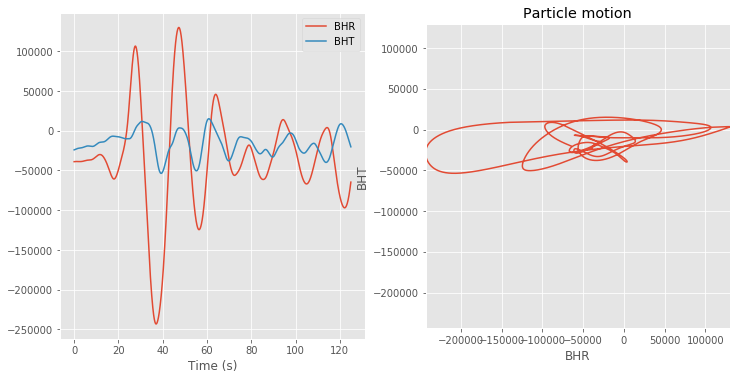

In [20]:
def plot_particle_motion(st):
    """
    Plot the horizontal particle motion for a given three-channel stream.
    """
    import numpy as np
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    channels = {tr.stats.channel: tr.data 
                for tr in st if tr.stats.channel[-1] != "Z"}
    keys = list(channels.keys())
    ax[1].plot(channels[keys[0]], channels[keys[1]])
    ax[1].set_xlabel(keys[0])
    ax[1].set_ylabel(keys[1])
    ax[1].set_title("Particle motion")
    ax[1].set_aspect('equal', 'box')
    ax[1].axis([
        min(min(channels[keys[0]]), min(channels[keys[1]])),
        max(max(channels[keys[0]]), max(channels[keys[1]])),
        min(min(channels[keys[0]]), min(channels[keys[1]])),
        max(max(channels[keys[0]]), max(channels[keys[1]])),
    ])
    
    time = np.arange(0, st[0].stats.npts * st[0].stats.delta,
                     st[0].stats.delta)
    ax[0].plot(time, channels[keys[0]], label=keys[0])
    ax[0].plot(time, channels[keys[1]], label=keys[1])
    ax[0].legend()
    ax[0].set_xlabel("Time (s)")
    return fig

arrival = [arrival for arrival in arrivals if arrival.name == "P"][0]
fig = plot_particle_motion(st_filtered.slice(
    event.preferred_origin().time + arrival.time - 5,
    event.preferred_origin().time + arrival.time + 120))

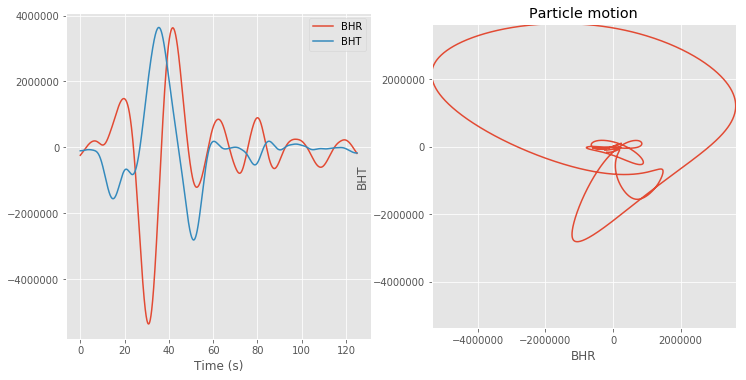

In [21]:
arrival = [arrival for arrival in arrivals if arrival.name == "S"][0]
fig = plot_particle_motion(st_filtered.slice(
    event.preferred_origin().time + arrival.time - 5,
    event.preferred_origin().time + arrival.time + 120))

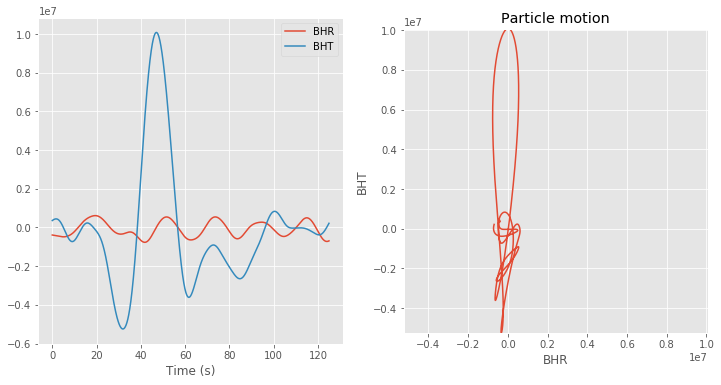

In [22]:
arrival = [arrival for arrival in arrivals if arrival.name == "sS"][0]
fig = plot_particle_motion(st_filtered.slice(
    event.preferred_origin().time + arrival.time - 5,
    event.preferred_origin().time + arrival.time + 120))

We can see very different particle motions for the three phases.  **Exercise:** Explain these differences.

**Answer:**

**Exercise:** Repeat the above but for [event 2018p816466](https://www.geonet.org.nz/earthquake/2018p816466) in the GeoNet catalog (use the "GEONET" client)
and download 5 minutes of data from station [VRZ](https://www.geonet.org.nz/data/network/sensor/VRZ).
Do you see significant S energy on the horizontal components? Try chaning the filter pass frequency.

In [35]:
# Write your code here - copy and paste things mostly an edit what needs to be editted.

## Conclusion

That concludes our very brief play with data.  Hopefully you have seen the different body-waves,
and that seismograms are a superposition of many different seismic phases.  In the following two
notebooks we will think about some of the other phenomena that we observe in these seismograms.